In [13]:
import os, random
import numpy as np
import pandas as pd

import kagglehub

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models

from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    confusion_matrix,
    classification_report,
    roc_auc_score,
    f1_score,
    accuracy_score,
)
from tqdm import tqdm

# Reproducibility
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)

# Use M1 GPU if available, else use CUDA, else CPU
# if cuda available up the N_PER_CLASS and epochs
if torch.backends.mps.is_available():
    device = torch.device("mps")
elif torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

print("Using device:", device)
torch.set_float32_matmul_precision("medium")


# Download dataset & load CSV
dataset_root = kagglehub.dataset_download("nih-chest-xrays/data")
print("Dataset root:", dataset_root)

csv_path = os.path.join(dataset_root, "Data_Entry_2017.csv")
df = pd.read_csv(csv_path)

# Binary target: 0 = No Finding, 1 = Any finding
df["target"] = (df["Finding Labels"] != "No Finding").astype(int)
print(df[["Image Index", "Finding Labels", "target"]].head())


# Map image filenames to paths
image_path_map = {}
for root, dirs, files in os.walk(dataset_root):
    for fname in files:
        if fname.lower().endswith((".png", ".jpg", ".jpeg")):
            image_path_map[fname] = os.path.join(root, fname)

coverage = df["Image Index"].isin(image_path_map.keys()).mean()
print(f"Image coverage: {coverage:.4f}")

# Keep only rows with actual image files
df = df[df["Image Index"].isin(image_path_map.keys())].reset_index(drop=True)


# Create balanced subset of dataset(dataset is huge so this ensures it runs in an acceptable amount of time)
N_PER_CLASS = 2000

df_small_list = []
for t in [0, 1]:
    subset = df[df["target"] == t]
    n = min(len(subset), N_PER_CLASS)
    df_small_list.append(subset.sample(n, random_state=SEED))

df_small = pd.concat(df_small_list).reset_index(drop=True)

print("Subset size:", len(df_small))
print(df_small["target"].value_counts())


# Patient-level train/val/test split
patients = df_small["Patient ID"].unique()

train_p, temp_p = train_test_split(patients, test_size=0.4, random_state=SEED)
val_p, test_p = train_test_split(temp_p, test_size=0.5, random_state=SEED)

def assign_split(pid):
    if pid in train_p:
        return "train"
    elif pid in val_p:
        return "val"
    else:
        return "test"

df_small["split"] = df_small["Patient ID"].apply(assign_split)

train_df = df_small[df_small["split"] == "train"].reset_index(drop=True)
val_df   = df_small[df_small["split"] == "val"].reset_index(drop=True)
test_df  = df_small[df_small["split"] == "test"].reset_index(drop=True)

print("Train/Val/Test sizes:", len(train_df), len(val_df), len(test_df))


# Dataset class + transforms
# image resize and augmentation
train_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.RandomResizedCrop(224, scale=(0.85, 1.0)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(degrees=7),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225],
    ),
])

eval_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225],
    ),
])

class ChestXrayDataset(Dataset):
    def __init__(self, df, image_path_map, transform=None):
        self.df = df.reset_index(drop=True)
        self.image_path_map = image_path_map
        self.transform = transform
        
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        img_name = row["Image Index"]
        img_path = self.image_path_map[img_name]
        img = Image.open(img_path).convert("RGB")
        if self.transform:
            img = self.transform(img)
        label = int(row["target"])
        return img, label


BATCH_SIZE = 16
NUM_WORKERS = 0 # 0 for mac M1

train_dataset = ChestXrayDataset(train_df, image_path_map, train_transform)
val_dataset = ChestXrayDataset(val_df, image_path_map, eval_transform)
test_dataset = ChestXrayDataset(test_df, image_path_map, eval_transform)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True,
                          num_workers=NUM_WORKERS)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False,
                          num_workers=NUM_WORKERS)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False,
                          num_workers=NUM_WORKERS)

print(len(train_loader), len(val_loader), len(test_loader))


# Define ResNet50 model (fine-tune last block + head)
resnet = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V1)

# Freeze everything first
for param in resnet.parameters():
    param.requires_grad = False

# Unfreeze last block + fc
for name, param in resnet.named_parameters():
    if name.startswith("layer4.") or name.startswith("fc."):
        param.requires_grad = True

# Replace final layer with a slightly richer head
num_feats = resnet.fc.in_features
resnet.fc = nn.Sequential(
    nn.Linear(num_feats, 256),
    nn.ReLU(inplace=True),
    nn.Dropout(p=0.3),
    nn.Linear(256, 1)
)

resnet = resnet.to(device)

criterion = nn.BCEWithLogitsLoss()

# Only optimize trainable params
trainable_params = [p for p in resnet.parameters() if p.requires_grad]
optimizer = torch.optim.Adam(trainable_params, lr=5e-5, weight_decay=1e-4)

scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer,
    mode="min",
    factor=0.5,
    patience=2
)


# Train/eval helpers
def train_one_epoch(model, loader, optimizer, criterion, device):
    model.train()
    running_loss, correct, total = 0.0, 0, 0
    
    for images, labels in tqdm(loader, desc="Train", leave=False):
        images = images.to(device)
        labels = labels.float().unsqueeze(1).to(device)
        
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item() * images.size(0)
        probs = torch.sigmoid(outputs)
        preds = (probs >= 0.5).long()
        correct += (preds == labels.long()).sum().item()
        total += labels.size(0)
    
    return running_loss / total, correct / total


def eval_one_epoch(model, loader, criterion, device):
    model.eval()
    running_loss, correct, total = 0.0, 0, 0
    all_labels, all_probs = [], []
    
    with torch.no_grad():
        for images, labels in tqdm(loader, desc="Eval", leave=False):
            images = images.to(device)
            labels = labels.float().unsqueeze(1).to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)
            running_loss += loss.item() * images.size(0)

            probs = torch.sigmoid(outputs)
            preds = (probs >= 0.5).long()
            correct += (preds == labels.long()).sum().item()
            total += labels.size(0)

            all_labels.extend(labels.cpu().numpy().flatten())
            all_probs.extend(probs.cpu().numpy().flatten())
    
    return running_loss / total, correct / total, np.array(all_labels), np.array(all_probs)


# Training loop
NUM_EPOCHS = 20 # adjust based on speed of machin

best_val_loss = float("inf")
best_state = None

for epoch in range(NUM_EPOCHS):
    print(f"\n===== Epoch {epoch+1}/{NUM_EPOCHS} =====")
    train_loss, train_acc = train_one_epoch(resnet, train_loader, optimizer, criterion, device)
    val_loss, val_acc, _, _ = eval_one_epoch(resnet, val_loader, criterion, device)
    scheduler.step(val_loss)

    print(f"Train loss {train_loss:.4f}, acc {train_acc:.3f} | "
          f"Val loss {val_loss:.4f}, acc {val_acc:.3f}")
    
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_state = resnet.state_dict().copy()
        print("  -> New best model")

if best_state is not None:
    resnet.load_state_dict(best_state)
    print("\nLoaded best validation model.")


# get best threshold on validation set
val_loss, val_acc, y_val_true, y_val_prob = eval_one_epoch(resnet, val_loader, criterion, device)
print(f"\nFinal VAL loss: {val_loss:.4f}, acc@0.5: {val_acc:.3f}")

best_thresh = 0.5
best_f1 = 0.0
best_acc = 0.0

for thr in np.linspace(0.1, 0.9, 17):  # 0.1, 0.15, ..., 0.9
    y_val_pred = (y_val_prob >= thr).astype(int)
    f1 = f1_score(y_val_true.astype(int), y_val_pred)
    acc = accuracy_score(y_val_true.astype(int), y_val_pred)
    if f1 > best_f1:
        best_f1 = f1
        best_acc = acc
        best_thresh = thr

print(f"Best VAL threshold: {best_thresh:.2f} | F1: {best_f1:.3f} | Acc: {best_acc:.3f}")


# Final test evaluation (0.5 and best threshold)
test_loss, test_acc_05, y_true, y_prob = eval_one_epoch(resnet, test_loader, criterion, device)
print(f"\nTest loss: {test_loss:.4f}, Test acc@0.5: {test_acc_05:.3f}")

# 0.5 threshold
y_pred_05 = (y_prob >= 0.5).astype(int)
cm_05 = confusion_matrix(y_true.astype(int), y_pred_05)
print("\n[Threshold = 0.5] Confusion matrix (rows=true, cols=pred):")
print(cm_05)

print("\n[Threshold = 0.5] Classification report:")
print(classification_report(
    y_true.astype(int),
    y_pred_05,
    target_names=["No Finding", "Any Finding"]
))

try:
    auc = roc_auc_score(y_true, y_prob)
    print(f"ROC-AUC: {auc:.4f}")
except ValueError:
    print("ROC-AUC could not be computed (only one class present).")

# best validation threshold
y_pred_best = (y_prob >= best_thresh).astype(int)
test_acc_best = accuracy_score(y_true.astype(int), y_pred_best)
test_f1_best = f1_score(y_true.astype(int), y_pred_best)
cm_best = confusion_matrix(y_true.astype(int), y_pred_best)

print(f"\n[Threshold = {best_thresh:.2f}] Test acc: {test_acc_best:.3f}, F1: {test_f1_best:.3f}")
print("[Threshold = {:.2f}] Confusion matrix (rows=true, cols=pred):".format(best_thresh))
print(cm_best)

print("\n[Threshold = {:.2f}] Classification report:".format(best_thresh))
print(classification_report(
    y_true.astype(int),
    y_pred_best,
    target_names=["No Finding", "Any Finding"]
))

# Optional: store test results for later analysis
test_results_df = pd.DataFrame({"y_true": y_true, "y_prob": y_prob})
test_results_df.head()


Using device: mps
Dataset root: /Users/graysonrichard/.cache/kagglehub/datasets/nih-chest-xrays/data/versions/3
        Image Index          Finding Labels  target
0  00000001_000.png            Cardiomegaly       1
1  00000001_001.png  Cardiomegaly|Emphysema       1
2  00000001_002.png   Cardiomegaly|Effusion       1
3  00000002_000.png              No Finding       0
4  00000003_000.png                  Hernia       1
Image coverage: 1.0000
Subset size: 4000
target
0    2000
1    2000
Name: count, dtype: int64
Train/Val/Test sizes: 2405 787 808
151 50 51

===== Epoch 1/20 =====


Train loss 0.6385, acc 0.649 | Val loss 0.6276, acc 0.661
  -> New best model

===== Epoch 2/20 =====


Train loss 0.5953, acc 0.687 | Val loss 0.6086, acc 0.676
  -> New best model

===== Epoch 3/20 =====


Train loss 0.5710, acc 0.709 | Val loss 0.6155, acc 0.673

===== Epoch 4/20 =====


Train loss 0.5516, acc 0.729 | Val loss 0.6586, acc 0.656

===== Epoch 5/20 =====


Train loss 0.5317, acc 0.741 | Val loss 0.6465, acc 0.659

===== Epoch 6/20 =====


Train loss 0.4838, acc 0.768 | Val loss 0.6576, acc 0.680

===== Epoch 7/20 =====


Train loss 0.4470, acc 0.802 | Val loss 0.7217, acc 0.658

===== Epoch 8/20 =====


Train loss 0.4298, acc 0.804 | Val loss 0.7562, acc 0.653

===== Epoch 9/20 =====


Train loss 0.3839, acc 0.833 | Val loss 0.8140, acc 0.633

===== Epoch 10/20 =====


Train loss 0.3657, acc 0.842 | Val loss 0.8204, acc 0.639

===== Epoch 11/20 =====


Train loss 0.3573, acc 0.844 | Val loss 0.8334, acc 0.663

===== Epoch 12/20 =====


Train loss 0.3099, acc 0.873 | Val loss 0.8173, acc 0.640

===== Epoch 13/20 =====


Train loss 0.3020, acc 0.870 | Val loss 0.8604, acc 0.634

===== Epoch 14/20 =====


Train loss 0.2936, acc 0.879 | Val loss 0.8656, acc 0.625

===== Epoch 15/20 =====


Train loss 0.2746, acc 0.887 | Val loss 0.8671, acc 0.638

===== Epoch 16/20 =====


Train loss 0.2700, acc 0.885 | Val loss 0.8789, acc 0.643

===== Epoch 17/20 =====


Train loss 0.2705, acc 0.888 | Val loss 0.8912, acc 0.648

===== Epoch 18/20 =====


Train loss 0.2779, acc 0.883 | Val loss 0.8942, acc 0.644

===== Epoch 19/20 =====


Train loss 0.2726, acc 0.883 | Val loss 0.9074, acc 0.659

===== Epoch 20/20 =====


Train loss 0.2534, acc 0.892 | Val loss 0.9085, acc 0.644

Loaded best validation model.



Final VAL loss: 0.9085, acc@0.5: 0.644
Best VAL threshold: 0.10 | F1: 0.693 | Acc: 0.601



Test loss: 0.9773, Test acc@0.5: 0.640

[Threshold = 0.5] Confusion matrix (rows=true, cols=pred):
[[250 171]
 [120 267]]

[Threshold = 0.5] Classification report:
              precision    recall  f1-score   support

  No Finding       0.68      0.59      0.63       421
 Any Finding       0.61      0.69      0.65       387

    accuracy                           0.64       808
   macro avg       0.64      0.64      0.64       808
weighted avg       0.64      0.64      0.64       808

ROC-AUC: 0.6725

[Threshold = 0.10] Test acc: 0.571, F1: 0.669
[Threshold = 0.10] Confusion matrix (rows=true, cols=pred):
[[110 311]
 [ 36 351]]

[Threshold = 0.10] Classification report:
              precision    recall  f1-score   support

  No Finding       0.75      0.26      0.39       421
 Any Finding       0.53      0.91      0.67       387

    accuracy                           0.57       808
   macro avg       0.64      0.58      0.53       808
weighted avg       0.65      0.57      0.52    

,y_true,y_prob
0,0.0,0.098478
1,0.0,0.176161
2,0.0,0.626207
3,0.0,0.391684
4,0.0,0.992597


In [14]:
# subgroup

In [15]:
# Subgroup evaluation: Age & Gender
import numpy as np
from sklearn.metrics import accuracy_score, roc_auc_score, f1_score

# test_df contains columns like: Patient Age, Patient Gender
test_df = test_df.reset_index(drop=True)

# Attach predictions to test dataframe
test_df["y_true"] = y_true
test_df["y_prob"] = y_prob
test_df["y_pred_05"] = (y_prob >= 0.5).astype(int)

# Gender groups
print("\n===== Subgroup Performance by Gender =====")
for gender in sorted(test_df["Patient Gender"].unique()):
    group = test_df[test_df["Patient Gender"] == gender]
    if len(group) < 5:
        continue

    y_t = group["y_true"].astype(int).values
    y_p = group["y_pred_05"].astype(int).values
    y_prob_g = group["y_prob"].values

    acc = accuracy_score(y_t, y_p)
    f1  = f1_score(y_t, y_p)
    try:
        auc = roc_auc_score(y_t, y_prob_g)
    except:
        auc = float('nan')

    print(f"\nGender: {gender}")
    print(f"  Count: {len(group)}")
    print(f"  Accuracy: {acc:.3f}")
    print(f"  F1 Score: {f1:.3f}")
    print(f"  ROC-AUC: {auc:.3f}")


# Age groups
print("\n===== Subgroup Performance by Age =====")
bins = [0, 20, 40, 60, 80, 120]
labels = ["0-20", "21-40", "41-60", "61-80", "81+"]

test_df["AgeGroup"] = pd.cut(test_df["Patient Age"], bins=bins, labels=labels, right=False)

for ag in labels:
    group = test_df[test_df["AgeGroup"] == ag]
    if len(group) < 5:
        continue

    y_t = group["y_true"].astype(int).values
    y_p = group["y_pred_05"].astype(int).values
    y_prob_g = group["y_prob"].values

    acc = accuracy_score(y_t, y_p)
    f1  = f1_score(y_t, y_p)
    try:
        auc = roc_auc_score(y_t, y_prob_g)
    except:
        auc = float('nan')

    print(f"\nAge Group: {ag}")
    print(f"  Count: {len(group)}")
    print(f"  Accuracy: {acc:.3f}")
    print(f"  F1 Score: {f1:.3f}")
    print(f"  ROC-AUC: {auc:.3f}")



===== Subgroup Performance by Gender =====

Gender: F
  Count: 365
  Accuracy: 0.674
  F1 Score: 0.699
  ROC-AUC: 0.699

Gender: M
  Count: 443
  Accuracy: 0.612
  F1 Score: 0.600
  ROC-AUC: 0.649

===== Subgroup Performance by Age =====

Age Group: 0-20
  Count: 52
  Accuracy: 0.519
  F1 Score: 0.419
  ROC-AUC: 0.533

Age Group: 21-40
  Count: 216
  Accuracy: 0.676
  F1 Score: 0.657
  ROC-AUC: 0.719

Age Group: 41-60
  Count: 352
  Accuracy: 0.648
  F1 Score: 0.659
  ROC-AUC: 0.678

Age Group: 61-80
  Count: 185
  Accuracy: 0.611
  F1 Score: 0.654
  ROC-AUC: 0.644


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/torch/nn/modules/module.py:1842: FutureWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  self._maybe_warn_non_full_backward_hook(args, result, grad_fn)


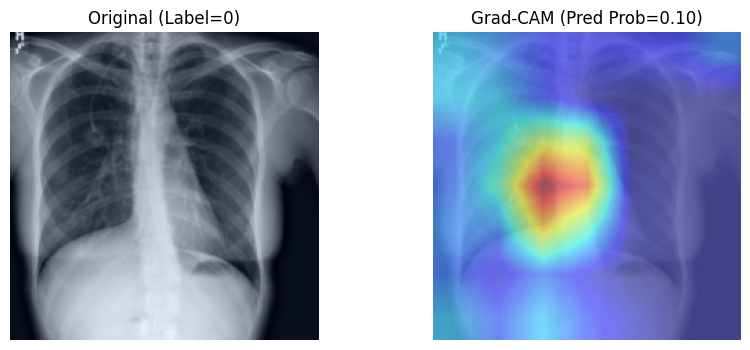

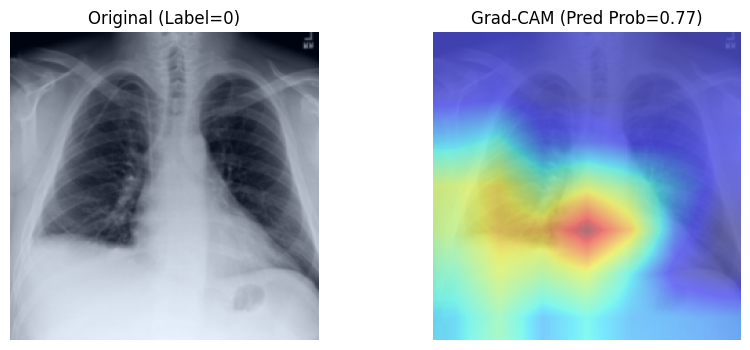

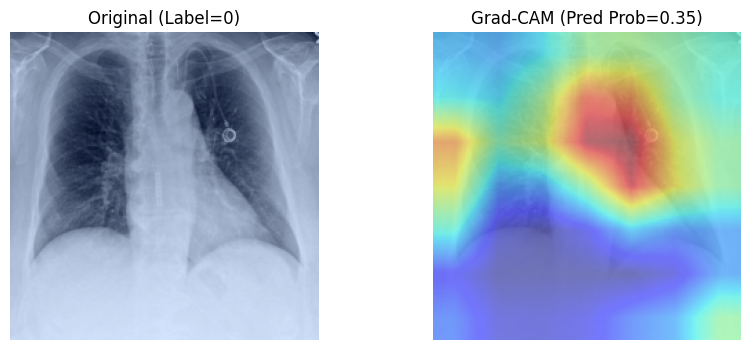

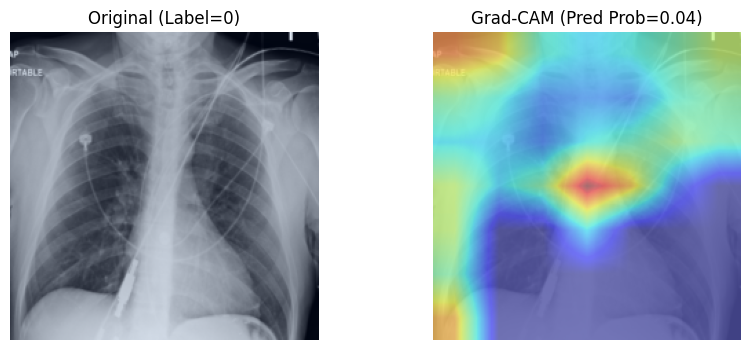

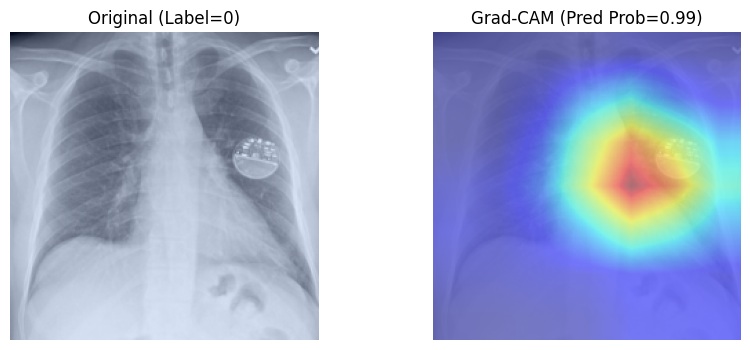

In [16]:
# Grad-CAM Heatmap Generation for a Few Test Images (working version)
import cv2
import matplotlib.pyplot as plt

# useing the last conv layer in layer4 of ResNet50
target_layer = resnet.layer4[-1].conv3

# Global holders for activations and gradients
gradcam_activations = []
gradcam_gradients = []

def forward_hook(module, input, output):
    # output: (N, C, H, W)
    gradcam_activations.append(output.detach())

def backward_hook(module, grad_input, grad_output):
    # grad_output[0]: (N, C, H, W)
    gradcam_gradients.append(grad_output[0].detach())

def generate_gradcam(model, img_tensor, target_layer):
    # Clear previous
    gradcam_activations.clear()
    gradcam_gradients.clear()

    model.eval()
    img_tensor = img_tensor.unsqueeze(0).to(device)  # (1, C, H, W)

    # Forward
    output = model(img_tensor)        # (1, 1)
    prob = torch.sigmoid(output)[0, 0].item()

    # Backward w.r.t. this scalar score
    model.zero_grad()
    output[0, 0].backward()

    # Get activations and gradients from hooks
    acts = gradcam_activations[0]     # (1, C, H, W)
    grads = gradcam_gradients[0]      # (1, C, H, W)

    acts = acts.squeeze(0).cpu().numpy()   # (C, H, W)
    grads = grads.squeeze(0).cpu().numpy() # (C, H, W)

    # Channel-wise weights
    weights = grads.mean(axis=(1, 2))      # (C,)

    # Weighted sum of activations
    cam = np.zeros(acts.shape[1:], dtype=np.float32)  # (H, W)
    for c, w in enumerate(weights):
        cam += w * acts[c]

    # ReLU + normalize
    cam = np.maximum(cam, 0)
    if cam.max() > 0:
        cam = cam / cam.max()

    # Resize to 224x224
    cam = cv2.resize(cam, (224, 224))

    return cam, prob

# Visualize a few test samples
indices_to_show = [0, 7, 10, 15, 20]  # adjust if needed

for i in indices_to_show:
    if i >= len(test_dataset):
        continue

    img, label = test_dataset[i]   # img is normalized tensor (C, H, W)
    heatmap, prob = generate_gradcam(resnet, img, target_layer)

    # Convert tensor -> [0,1] RGB for display
    img_np = img.permute(1, 2, 0).cpu().numpy()
    img_np = (img_np - img_np.min()) / (img_np.max() - img_np.min() + 1e-8)

    plt.figure(figsize=(10, 4))
    plt.subplot(1, 2, 1)
    plt.title(f"Original (Label={int(label)})")
    plt.imshow(img_np)
    plt.axis("off")

    plt.subplot(1, 2, 2)
    plt.title(f"Grad-CAM (Pred Prob={prob:.2f})")
    plt.imshow(img_np, alpha=0.5)
    plt.imshow(heatmap, cmap="jet", alpha=0.5)
    plt.axis("off")

    plt.show()